---
layout: post  
---

Here we are designing a "tip-clipping" algorithm.

One of the strengths of using a graph-based error-correction strategy is that we have contextual awareness. Each region of the sequence is evaluated based on the information that is currently under consideration as well as all preceeding information and all following information.

This tends to produce well corrected graph structure within the graph. Incorrect tips/edges of the graph with degree 1 often esacpe correction, however. Given they only have context in one direction, we miss out on the additional statistical power of bi-directional context.

As a final graph cleaning step after the viterbi correction process, we can search for all of these tips and then remove any tips that have very low evidence to support them.

Initially, we will define low evidence as anything with a single supporting read OR anything with coverage that is more than 3 standard deviations below the median coverage of the rest of the connected component of the graph.

The single supporting read limit does mean that in low coverage libraries, some true tips may be clipped, however I'd prefer to take this conservative approach to avoid issues with high-coverage libraries as demonstrated below.

In [1]:
import Pkg
pkgs = [
    "Eisenia",
    "Random",
    "Revise",
    "BioSequences",
    "Test",
    "LightGraphs",
    "Primes",
    "Statistics",
    "Plots"
]

for pkg in pkgs
    try
        Pkg.add(pkg)
    catch
#         # tried to install an unregistered local package
    end
    eval(Meta.parse("import $pkg"))
end

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes

Here we define the paramters of the simulation to be the same 10bp reference sequence observed 100 times as in previous posts

In [2]:
n_sequences = 1
seqlen = 10
n_observations = 100
error_rate = 0.05

0.05

In [3]:
sequences = [BioSequences.randdnaseq(Random.seed!(i), seqlen) for i in 1:n_sequences]    

1-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 TCGTCCCAGG

In [4]:
Random.seed!(1)
observations = [
    Eisenia.observe(rand(sequences), error_rate = error_rate) 
        for i in 1:n_observations
]

100-element Array{BioSequences.LongSequence{BioSequences.DNAAlphabet{4}},1}:
 CCTGGGACGA
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGGATCGA
 CCTGGGACGA
 TCGTCCCAGG
 TCGTCCAGG
 TGTCCCAGG
 CCTGGGACGA
 CCTGGGACGA
 CCTGGGACCA
 TCGTCCCAGG
 CCTGGGACGA
 ⋮
 TCGTCCCAGCG
 TCGTCCCATG
 TCGTCCCAGG
 TCGTCCCAGG
 TCGTCCCAGG
 CCTGGGACGA
 CCTGGCGACGA
 TCGTCCCAGG
 TCGTCCCAGG
 TCACGTCCCGAGG
 CCTGGGACGA
 TCGCTCCCAGG

The initial graph is complex with lots of low frequency error nodes, but the majority of the erroneous structure is resolved in 4 iterations

"k = 3"

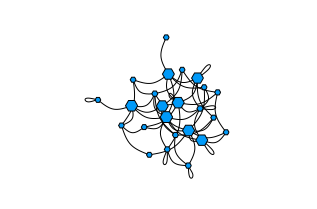

![](/assets/images/11516063661208544668.svg)

"reads_processed = 100"

"total_edits_accepted = 37"

"inferred_error_rate = 0.037"

"k = 5"

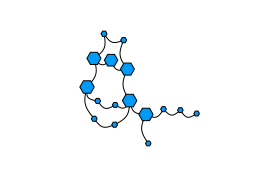

![](/assets/images/9366657123667438041.svg)

"reads_processed = 100"

"total_edits_accepted = 17"

"inferred_error_rate = 0.017"

"k = 7"

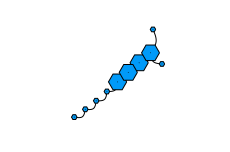

![](/assets/images/7625239065058145842.svg)

"reads_processed = 100"

"total_edits_accepted = 9"

"inferred_error_rate = 0.009"

"final graph"

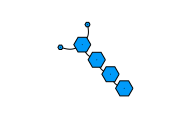

![](/assets/images/16902361047499149513.svg)

In [5]:
graph, corrected_observations = Eisenia.iterate_until_convergence(Primes.primes(3, 7), observations, error_rate);

In this final graph produced by the viterbi error correction procedure, we can see the 4 core large nodes and the 2 outlier tips. These tips are what we're striving to algorithmically remove

Let's extract the connected component and evaluate the coverage of each node to begin working towards a coverage-based tip clipping implementation

In [6]:
connected_components = LightGraphs.connected_components(graph.graph)
@assert length(connected_components) == 1
connected_component = first(connected_components)

6-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6

With the connected component extracted, we can review the coverage for each of the nodes

In [7]:
coverage = graph.counts[connected_component]

6-element Array{Int64,1}:
 99
 98
  1
 98
  1
 96

We can see above that core nodes have coverage ~100 and an overall median coverage of 97, very close to the 100 simulated reads of coverage we initiated this experiment with

In [8]:
median_coverage = Statistics.median(coverage)

97.0

Because there are so few nodes, the 2 outliers are 1/3 of the total data points in our coverage evaluation, making the standard deviation > 50% of the median coverage

In [9]:
coverage_std = Statistics.std(coverage)

49.97099158511866

In larger graphs with a greater relative frequency of high-coverage (confident) nodes relative to erroneous tips, I imagine we'd be able to do more probabilistic tip clipping by removing any nodes with < 3 standard deviations of coverage. Here we will also hard-clip any tips with 1x coverage, which is sufficient to handle the outlier nodes in this example

In [10]:
vertices_to_keep = Int[]
for vertex in connected_component
    
    this_degree = LightGraphs.degree(graph.graph, vertex)
    
    this_coverage = graph.counts[vertex]
    magnitude_below_median = median_coverage - graph.counts[vertex]
    
    is_low_coverage = (this_coverage == 1) || (magnitude_below_median >= 3*coverage_std)
    
    if (this_degree == 1) && is_low_coverage
        @show vertex
    else
        push!(vertices_to_keep, vertex)
    end
end

vertex = 3
vertex = 5


Above we see that we've flagged the two low coverage outlier nodes for removal while the rest have been added to a "vertices_to_keep" vector

Here we are able to confirm that the set of kmers that we have selected to keep after throwing out low frequency outliers are equivalent to the set of kmers in the original target sequence that we are trying to reconstruct

In [11]:
true_kmers = collect(keys(Eisenia.count_kmers(BioSequences.DNAMer{7}, sequences)))
verified_true_kmers = findall(kmer -> kmer in true_kmers, graph.kmers)
vertices_to_keep == verified_true_kmers

true

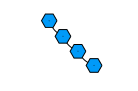

![](/assets/images/16724666220107000699.svg)

In [12]:
KmerType = first(typeof(graph).parameters)
new_graph = Eisenia.KmerGraph(KmerType, observations, graph.kmers[vertices_to_keep], graph.counts[vertices_to_keep])
Eisenia.my_plot(new_graph)

And here we see that we've rebuild a clean graph with only the core structure remaining!

Now, we'll pull out the connected component and walk the graph to resolve the primary path

In [13]:
connected_components = LightGraphs.connected_components(new_graph.graph)
@assert length(connected_components) == 1
connected_component = first(connected_components)
maximum_likelihood_walk = Eisenia.take_a_walk(new_graph, connected_component)

4-element Array{Eisenia.OrientedKmer,1}:
 Eisenia.OrientedKmer(1, true)
 Eisenia.OrientedKmer(3, true)
 Eisenia.OrientedKmer(2, false)
 Eisenia.OrientedKmer(4, true)

In [14]:
resolved_sequence = Eisenia.oriented_path_to_sequence(maximum_likelihood_walk, new_graph.kmers)

10nt DNA Sequence:
CCTGGGACGA

In [15]:
original_sequence = first(sequences)

10nt DNA Sequence:
TCGTCCCAGG

In [16]:
Eisenia.is_equivalent(resolved_sequence, original_sequence)

true

To recap, we've shown how to resolve errors in graph tips based on coverage relative to the rest of the connected component. Hopefully this method with generalize well to larger, more complex graphs